# The random dimer model

Requirements
+ matplotlib
+ numpy
+ scipy


<!-- [Click here to open this notebook in Colab](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/hw/random_dimer.ipynb) -->

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/hw/random_dimer.ipynb)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Autoreload
# %load_ext autoreload
# %autoreload 2

In [ ]:
import numpy as np, matplotlib.pyplot as plt

class MinimalSquareDimers:
    """Close-packed dimers on an Lx x Ly square lattice with periodic BCs."""
    def __init__(self, Lx=20, Ly=20, seed=None):
        assert Lx % 2==0 and Ly % 2==0 ## Ensure that the lattice is even
        self.Lx, self.Ly = Lx, Ly
        self.rng = np.random.default_rng(seed)
        self.H = np.zeros((Ly, Lx), np.uint8)     # edge (x,y)-(x+1,y) occupied?
        self.V = np.zeros((Ly, Lx), np.uint8)     # edge (x,y)-(x,y+1) occupied?
        self.H[:, ::2] = 1                       # horizontal stripes = valid initial covering

    # ---- tiny helpers ----
    def _occ_edge_from(self, x, y):
        """Return neighbor of the unique occupied edge touching (x,y)."""
        xm, ym = (x-1)%self.Lx, (y-1)%self.Ly
        if self.H[y, xm]:  return ((x-1)%self.Lx, y)
        if self.H[y, x]:   return ((x+1)%self.Lx, y)
        if self.V[ym, x]:  return (x, (y-1)%self.Ly)
        if self.V[y, x]:   return (x, (y+1)%self.Ly)
        raise RuntimeError("Constraint broken")

    def _toggle(self, x1,y1,x2,y2):
        """XOR the edge occupancy on (x1,y1)-(x2,y2)."""
        if y1==y2:
            xlo = x1 if (x2-x1)%self.Lx==1 else x2
            self.H[y1, xlo] ^= 1
        else:
            ylo = y1 if (y2-y1)%self.Ly==1 else y2
            self.V[ylo, x1] ^= 1

    # ---- a) one local plaquette flip (do nothing if not flippable) ----
    def flip_plaquette_once(self):
        x = int(self.rng.integers(self.Lx)); y = int(self.rng.integers(self.Ly))
        xn, yn = (x+1)%self.Lx, (y+1)%self.Ly
        b, t, l, r = self.H[y,x], self.H[yn,x], self.V[y,x], self.V[y,xn]
        if (b and t and not l and not r) or (l and r and not b and not t):
            self.H[y,x] ^= 1; self.H[yn,x] ^= 1; self.V[y,x] ^= 1; self.V[y,xn] ^= 1
            return True
        return False

    # ---- b) one nonlocal loop (worm) update (uniform measure ⇒ accept=1) ----
    def loop_update_once(self, max_steps=10000):
        x0 = int(self.rng.integers(self.Lx)); y0 = int(self.rng.integers(self.Ly))
        xh, yh = self._occ_edge_from(x0, y0)      # break a dimer → two monomers
        self._toggle(x0,y0,xh,yh)
        tail, head = (x0,y0), (xh,yh)
        prev = tail
        for step in range(max_steps):
            x,y = head
            nbrs = [((x+1)%self.Lx,y),((x-1)%self.Lx,y),(x,(y+1)%self.Ly),(x,(y-1)%self.Ly)]
            nbrs = [nb for nb in nbrs if nb!=prev]    # avoid immediate backtrack
            # edge occupancy to each neighbor:
            occ = []
            for xn,yn in nbrs:
                if yn==y:
                    xlo = x if (xn-x)%self.Lx==1 else xn; occ.append(self.H[y,xlo])
                else:
                    ylo = y if (yn-y)%self.Ly==1 else yn; occ.append(self.V[ylo,x])
            want_occ = (step%2==0)                    # even: add (currently empty)
            cands = [nb for nb,o in zip(nbrs,occ) if o==want_occ] or nbrs
            nb = cands[self.rng.integers(len(cands))]
            self._toggle(x,y,nb[0],nb[1])
            prev, head = (x,y), nb
            if head==tail: return True
        # fail to close → revert the first break
        self._toggle(x0,y0,xh,yh); return False

    # ---- plotting ----
    def plot(self):
        fig, ax = plt.subplots(figsize=(5,5))
        for y in range(self.Ly):
            for x in range(self.Lx):
                if self.H[y,x] and (x+1)%self.Lx>x: ax.plot([x,x+1],[y,y], linewidth=3)
        for y in range(self.Ly):
            for x in range(self.Lx):
                if self.V[y,x] and (y+1)%self.Ly>y: ax.plot([x,x],[y,y+1], linewidth=3)
        ax.set_aspect('equal'); ax.set_xlim(0,self.Lx); ax.set_ylim(0,self.Ly)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_title("Square-lattice dimers")
        plt.show()
        return ax

D = MinimalSquareDimers(Lx=20, Ly=20, seed=1)
energies = [D.energy()]
for _ in range(1000): 
    D.flip_plaquette_once()
    energies.append(D.energy())
# for _ in range(200):  
#     D.loop_update_once()
#     energies.append(D.energy())

plt.plot(energies)

D.plot()

AttributeError: 'MinimalSquareDimers' object has no attribute 'energy'

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh

class RandomDimerModel:
    """
    1D tight-binding random dimer model (RDM):
      H = sum_n [ ε_n |n><n| - t ( |n><n+1| + |n+1><n| ) ]
    with ε_n taking two values {va, vb} but inserted as *dimers* (pairs).
    """
    def __init__(self, N=2000, t=1.0, va=-0.5, vb=+0.5, pair_prob=0.5, seed=None):
        """
        N: chain length
        t: nearest-neighbor hopping
        va, vb: onsite energies for the two species
        pair_prob: P(dimer == 'a'); otherwise 'b'
        """
        self.N = int(N)
        self.t = float(t)
        self.va, self.vb = float(va), float(vb)
        self.pair_prob = float(pair_prob)
        self.rng = np.random.default_rng(seed)
        self.eps = self._make_random_dimer_sequence()
        self._ham_cache_dense = None
        self._ham_cache_sparse = None
        self._spec = None  # (evals, evecs) once computed

    # ---------- core construction ----------
    def _make_random_dimer_sequence(self):
        eps = np.empty(self.N, dtype=float)
        i = 0
        while i < self.N:
            kind_a = self.rng.random() < self.pair_prob
            val = self.va if kind_a else self.vb
            if i == self.N - 1:
                eps[i] = val
                i += 1
            else:
                eps[i:i+2] = val
                i += 2
        return eps

    def hamiltonian_sparse(self):
        if self._ham_cache_sparse is None:
            main = self.eps
            off = -self.t * np.ones(self.N-1)
            self._ham_cache_sparse = diags([main, off, off], [0, -1, 1], format='csc')
        return self._ham_cache_sparse

    def hamiltonian_dense(self):
        if self._ham_cache_dense is None:
            H = np.diag(self.eps)
            off = -self.t * np.ones(self.N-1)
            H[np.arange(self.N-1), np.arange(1, self.N)] = off
            H[np.arange(1, self.N), np.arange(self.N-1)] = off
            self._ham_cache_dense = H
        return self._ham_cache_dense

    # ---------- spectra & observables ----------
    def spectrum(self, k=None):
        """
        Return (evals, evecs). If k is None or k >= N, uses dense solver.
        For large N, choose k << N (e.g., 400) for partial spectrum with eigsh.
        """
        if k is None or k >= self.N:
            evals, evecs = LA.eigh(self.hamiltonian_dense())
        else:
            # Center the spectrum around 0 by shift-invert if desired; here simple eigsh extremes + middle sweep
            # We get k//2 lowest, k//2 highest, then merge (simple & robust).
            k_low = k//2
            k_high = k - k_low
            Hs = self.hamiltonian_sparse()
            lo_vals, lo_vecs = eigsh(Hs, k=k_low, which='SA')
            hi_vals, hi_vecs = eigsh(Hs, k=k_high, which='LA')
            evals = np.concatenate([lo_vals, hi_vals])
            evecs = np.concatenate([lo_vecs, hi_vecs], axis=1)
            order = np.argsort(evals)
            evals, evecs = evals[order], evecs[:, order]
        self._spec = (evals, evecs)
        return evals, evecs

    def ipr(self, evecs=None):
        """Inverse Participation Ratio of eigenvectors: IPR(ψ)=∑|ψ_n|^4."""
        if evecs is None:
            if self._spec is None: self.spectrum()
            evecs = self._spec[1]
        return np.sum(np.abs(evecs)**4, axis=0)

    def dos(self, bins=200, rng=None, eigenvalues=None):
        """Density of states (histogram of eigenvalues)."""
        if eigenvalues is None:
            if self._spec is None: self.spectrum()
            eigenvalues = self._spec[0]
        if rng is None:
            bandwidth = 2*abs(self.t) + max(abs(self.va), abs(self.vb)) + 1e-6
            rng = (-bandwidth, +bandwidth)
        hist, edges = np.histogram(eigenvalues, bins=bins, range=rng, density=True)
        centers = 0.5*(edges[:-1] + edges[1:])
        return centers, hist

    # ---------- transfer matrix / Lyapunov exponent ----------
    def lyapunov(self, E, periodic_bc=False):
        """
        Compute Lyapunov exponent γ(E) via product of 2x2 transfer matrices.
        For large N this estimates the inverse localization length.
        """
        t = self.t
        # Avoid exact singularities
        eps = self.eps
        # Initialize with a random unit vector to reduce alignment bias
        v = np.array([1.0, 0.0])
        log_norm_sum = 0.0
        count = 0
        for n in range(self.N):
            M = np.array([[ (E - eps[n])/t, -1.0 ], [ 1.0, 0.0 ]], dtype=float)
            v = M @ v
            nrm = np.hypot(v[0], v[1])
            if nrm == 0:  # rare; reset
                v = np.array([1.0, 0.0])
                continue
            v /= nrm
            log_norm_sum += np.log(nrm)
            count += 1
        # Optional boundary closure (minor effect on large N)
        if periodic_bc:
            M_bc = np.array([[ (E - eps[0])/t, -1.0 ], [ 1.0, 0.0 ]], dtype=float)
            v = M_bc @ v
            log_norm_sum += np.log(np.hypot(v[0], v[1]))
            count += 1
        return log_norm_sum / max(count,1)

    def lyapunov_scan(self, Emin=None, Emax=None, nE=401):
        if Emin is None or Emax is None:
            bw = 2*abs(self.t) + max(abs(self.va), abs(self.vb)) + 1e-3
            Emin, Emax = -bw, +bw
        Es = np.linspace(Emin, Emax, nE)
        gam = np.array([self.lyapunov(E) for E in Es])
        return Es, gam

    # ---------- visualization ----------
    def plot_all(self, n_states_to_plot=6, figsize=(12,10)):
        """
        Convenience visualization:
          (1) onsite potential ε_n
          (2) DOS(E)
          (3) IPR vs E (small IPR => extended)
          (4) A few representative eigenstates |ψ_n|^2
          (5) Lyapunov exponent γ(E)
        """
        if self._spec is None: self.spectrum()

        evals, evecs = self._spec
        ipr_vals = self.ipr(evecs)
        E_dos, rho = self.dos(eigenvalues=evals)

        Es, gam = self.lyapunov_scan()

        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(3, 2)

        # (1) potential
        ax = fig.add_subplot(gs[0,0])
        ax.plot(self.eps, lw=0.8)
        ax.set_title(r"Onsite potential $\epsilon_n$")
        ax.set_xlabel("n")
        ax.set_ylabel(r"$\epsilon_n$")

        # (2) DOS
        ax = fig.add_subplot(gs[0,1])
        ax.plot(E_dos, rho, lw=1.0)
        ax.set_title("Density of states")
        ax.set_xlabel("E")
        ax.set_ylabel(r"$\rho(E)$")

        # (3) IPR vs E
        ax = fig.add_subplot(gs[1,0])
        ax.scatter(evals, ipr_vals, s=6)
        ax.set_title("IPR vs eigenenergy")
        ax.set_xlabel("E")
        ax.set_ylabel("IPR")

        # (4) example eigenstates near resonance energies (if present)
        ax = fig.add_subplot(gs[1,1])
        targets = [self.va, self.vb]
        picked = []
        for E0 in targets:
            j = np.argmin(np.abs(evals - E0))
            if j not in picked:
                picked.append(j)
        # fill remaining slots by evenly spaced indices
        while len(picked) < n_states_to_plot:
            picked.append(int(len(picked)*len(evals)/(n_states_to_plot+1)))
        for j in picked[:n_states_to_plot]:
            ax.plot(np.abs(evecs[:, j])**2, lw=0.9, alpha=0.9, label=f"E={evals[j]:.3f}")
        ax.set_title(r"Selected eigenstates $|\psi_n|^2$")
        ax.set_xlabel("n")
        ax.set_ylabel(r"$|\psi_n|^2$")
        ax.legend(loc="upper right", fontsize=8, frameon=False)

        # (5) Lyapunov exponent
        ax = fig.add_subplot(gs[2, :])
        ax.plot(Es, gam, lw=1.0)
        ax.axvline(self.va, ls='--')
        ax.axvline(self.vb, ls='--')
        ax.set_title(r"Lyapunov exponent $\gamma(E)$ (1/$\xi$)")
        ax.set_xlabel("E")
        ax.set_ylabel(r"$\gamma(E)$")
        ax.text(0.01, 0.93, f"va={self.va:.3f}, vb={self.vb:.3f}, t={self.t:.3f}", transform=ax.transAxes)

        fig.tight_layout()
        return fig

    # ---------- utilities ----------
    def reset_disorder(self, pair_prob=None, seed=None):
        if pair_prob is not None: self.pair_prob = float(pair_prob)
        if seed is not None: self.rng = np.random.default_rng(seed)
        self.eps = self._make_random_dimer_sequence()
        self._ham_cache_dense = None
        self._ham_cache_sparse = None
        self._spec = None

    def summary(self):
        return dict(N=self.N, t=self.t, va=self.va, vb=self.vb, pair_prob=self.pair_prob)


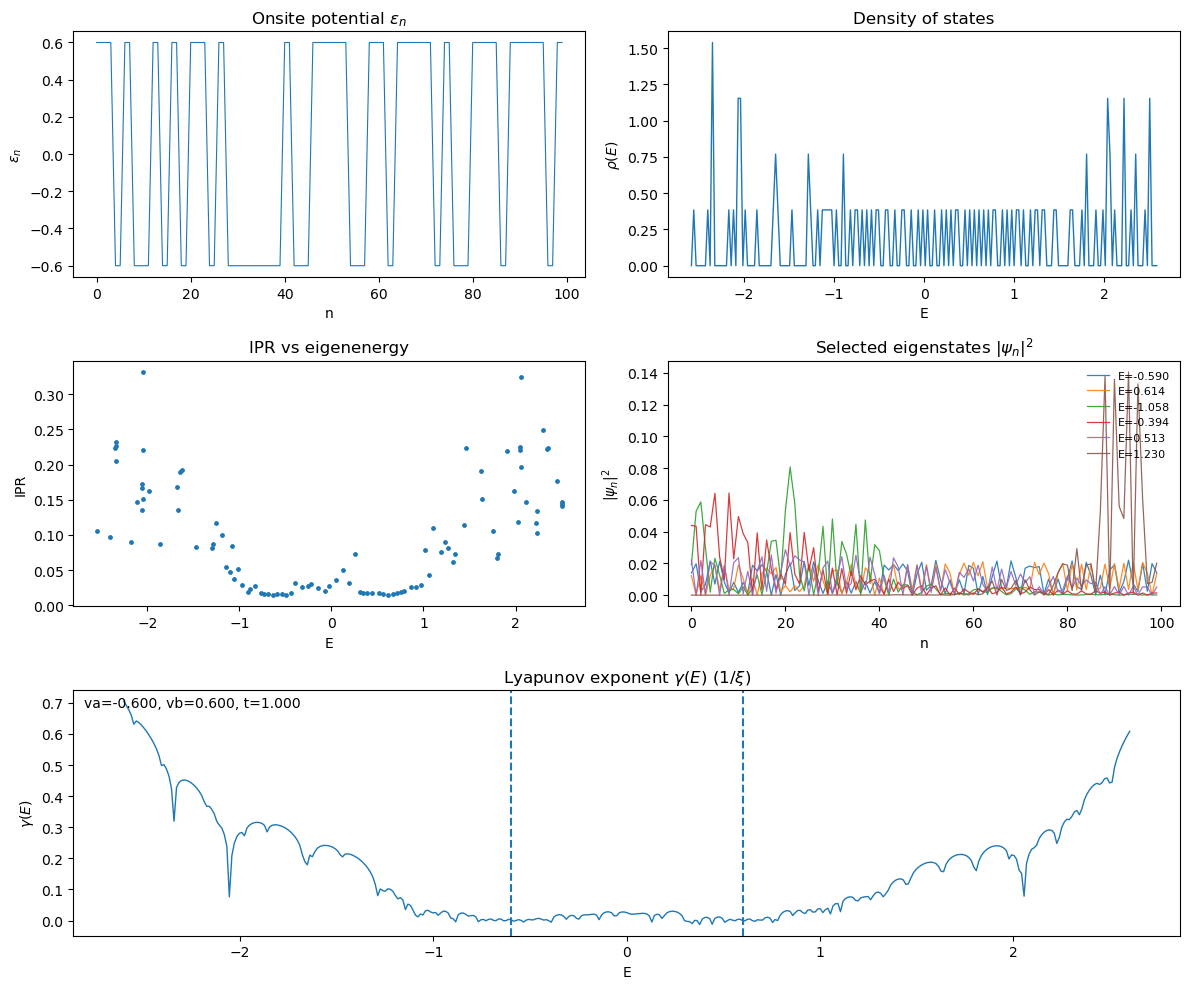

In [3]:
rdm = RandomDimerModel(N=100, t=1.0, va=-0.6, vb=+0.6, pair_prob=0.5, seed=1)
rdm.spectrum(k=600)   # or None for full spectrum on small N
fig = rdm.plot_all()